<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/R_10_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')
tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)

tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatana = tilyvoafar.get_group('Antananarivo')
tilyvoatana.set_index('Daty', inplace=True)

tilyvoatana.index = pd.to_datetime(tilyvoatana.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)

tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Voa vaovao (observed incidence)
Ivao = tilyvoamdg['Voatomb']

dIvao = pd.DataFrame(data =Ivao)

dIvao['Datint'] = range(len(Ivao))


# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,5,9)
daty_data_mifar = datetime.date(2020,5,26)

datyt = daty_data_mifar - datetime.timedelta(days = 1)

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)
datyf_data_manom = format_date(daty_data_manom)
datyf_data_mifar = format_date(daty_data_mifar)

# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh


def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1 The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  for i in range(k):
    Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2 Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# but include the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  for i in range(k):
    Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := um(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3 The sum of total infectiousness before t over a generic window (t-k+1,t)

def tlsi(t,k):
  tlsi = 0
  for i in range(k):
    tlsi = tlsi + lsi(t - datetime.timedelta(days = k))
  return tlsi

# 4 The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = Isi(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k))/(1 + si(t+1, t - daty_data_manom + 2)*(1/si_sc + Isi(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k))/(1 + lsi(t+datetime.timedelta(days = 1))*(1/si_sc + tlsi(t,k)))

# pnb(t,k) dia mikajy ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5 Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [7]:
# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

For k = 9, APE91 = 732.0185801822297
APEt91 = [(207.504697534463, datetime.date(2020, 5, 25)), (50.37368602842332, datetime.date(2020, 5, 24)), (146.35795412484075, datetime.date(2020, 5, 23)), (127.13452951732944, datetime.date(2020, 5, 22)), (109.54287505080116, datetime.date(2020, 5, 21)), (41.748474797474984, datetime.date(2020, 5, 20)), (35.93300328323204, datetime.date(2020, 5, 19)), (13.423359845664947, datetime.date(2020, 5, 18))]
Prt91 = [7.618244236528508e-91, 1.327352049491507e-22, 2.7387232010533045e-64, 6.111887775376667e-56, 2.6676806191233124e-48, 7.393801169861095e-19, 2.4802471306619853e-16, 1.480160773026277e-06]
For k = 9, APE92 = 57.125906967189415
APEt92= [(3.572919968013867, datetime.date(2020, 5, 17), 9), (3.3968670033351565, datetime.date(2020, 5, 16), 8), (8.141364427294548, datetime.date(2020, 5, 15), 7), (9.867252325792006, datetime.date(2020, 5, 14), 6), (4.84850084060324, datetime.date(2020, 5, 13), 5), (4.177287250483859, datetime.date(2020, 5, 12), 4), (1

In [8]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
  APEk1.append(APEj1)

print('APEk1 =', APEk1)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [1494.690641395493, 1421.2136614060641, 1322.2456488114597, 1225.7352883554145, 1107.2975752228226, 1002.0183837133259, 871.0481466956976]
APEk2 = [6.916395128556711, 23.12171515166675, 27.29900240215061, 32.14750324275384, 42.014755568545844, 50.15611999584039, 53.55298699917555]


In [9]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

print('APE9 =', APE9)
print('APEk =', APEk)

APE9 = 789.1444871494191
APEk = [1501.6070365240498, 1444.3353765577308, 1349.5446512136102, 1257.8827915981683, 1149.3123307913684, 1052.1745037091662, 924.6011336948732]


In [10]:
# Prior Gamma distribution of Rt

Rtpr_sh = 0.1 # shape
Rtpr_sc =  0.1 # scale

# Posterior distribution for Rt

# Shape parameter :
def Rtps_sh(t):
   return Rtpr_sh + Ireh(t,9)

# Scale
def Rtps_sc(t):
  return 1/(1/Rtpr_sc + tlsi(t,9))

# mean
def Rtps_salan(t):
  return Rtps_sh(t)*Rtps_sc(t)

print("Salan'isa R hoan'ny", datyt, ':', Rtps_salan(datyt))

# 95th and 5th percentiles

def perc95(t):
  return gengamma.ppf(0.95, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))

def perc05(t):
  return gengamma.ppf(0.05, Rtps_sh(t), 1, loc = 0, scale = Rtps_sc(t))


# for plotting

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, date_py.month)

daty_lst = []

salan_Rt = []
perc95_lst = []
perc05_lst = []

salan_Rt_dat = []
salan_Rt_perc_dat = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) - 1)):
  t = daty_data_manom + datetime.timedelta(days = i+1)
  daty = formatf_date(t)
  daty_lst.append(daty)
  salan_Rt.append(Rtps_salan(t))
  perc95_lst.append(perc95(t))
  perc05_lst.append(perc05(t))
  salan_Rt_dat.append((Rtps_salan(t),t))
  salan_Rt_perc_dat.append((perc95(t),Rtps_salan(t),perc05(t),t))

salan_Rt_perc_dat

Salan'isa R hoan'ny 2020-05-25 : 3.583629688418945


[(4.992166663846674, 3.91, 2.9413773420805533, datetime.date(2020, 5, 10)),
 (6.339861271705853, 5.11, 3.9937203467836215, datetime.date(2020, 5, 11)),
 (5.443651734325651,
  4.3100000000000005,
  3.2899071584026176,
  datetime.date(2020, 5, 12)),
 (7.670932918031564,
  6.3100000000000005,
  5.062671914411912,
  datetime.date(2020, 5, 13)),
 (9.427511055602324, 7.91, 6.506113715685868, datetime.date(2020, 5, 14)),
 (9.536743454277362, 8.01, 6.596882297354921, datetime.date(2020, 5, 15)),
 (14.082596143862368, 12.21, 10.451056233235619, datetime.date(2020, 5, 16)),
 (15.691108382393152, 13.71, 11.842549538551975, datetime.date(2020, 5, 17)),
 (17.40048261551094, 15.31, 13.33318001830643, datetime.date(2020, 5, 18)),
 (16.498495651229593,
  14.527954696959263,
  12.663880097138275,
  datetime.date(2020, 5, 19)),
 (17.139138847781346,
  15.249809741975955,
  13.454129470538556,
  datetime.date(2020, 5, 20)),
 (12.822020804717075,
  11.496671173251302,
  10.23264826665223,
  datetime.date(

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


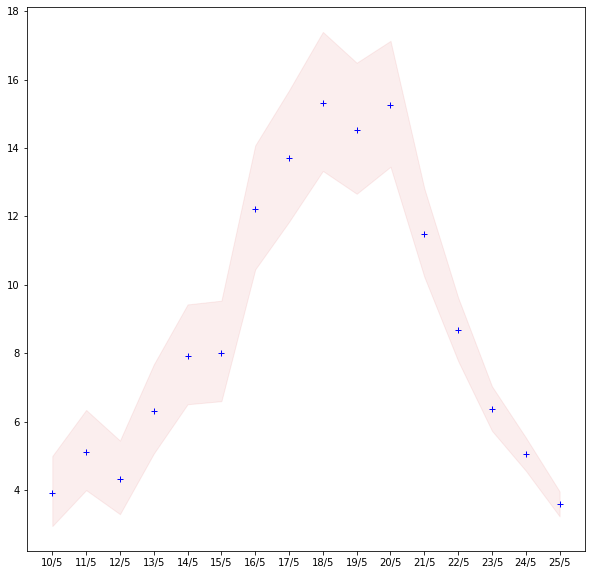

In [11]:
# Plotting

fig = plt.figure(figsize=(10, 10))

plt.plot(daty_lst, salan_Rt, 'b',  marker ="+",ls = 'None')
plt.fill_between(daty_lst, perc05_lst, perc95_lst, alpha=0.08, color="tab:red")

plt.savefig(path_to_save+'R_10_25.eps')
plt.show()